# Model evaluation on test set and subission process

In [0]:
import os
import cv2
import pdb
import time
import random
import numpy as np
import pandas as pd
import sys

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt

In [4]:
# !pip install -U git+https://github.com/albu/albumentations
# !pip install git+https://github.com/aleju/imgaug.git
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
!pip install pydicom
!pip install git+https://github.com/qubvel/ttach
import albumentations
import segmentation_models_pytorch as smp
import pydicom
import ttach

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-5kifiux5
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-5kifiux5
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.1.0-cp36-none-any.whl size=41517 sha256=bb9e5e3691711bb825472718b1d3f12dec1d488200b1cfd1d678d9de5653b821
  Stored in directory: /tmp/pip-ephem-wheel-cache-xl2rxugg/wheels/79/3f/09/1587a252e0314d26ad242d6d2e165622ab95c95e5cfe4b942c
Successfully built segmentation-models-pytorch
  Cloning https://github.com/qubvel/ttach to /tmp/pip-req-build-er1ofgim
  Running command git clone -q https://github.com/qubvel/ttach /tmp/pip-req-build-er1ofgim
  Created wheel for ttach: filename=ttach-0.0.2-cp36-none-any.whl size=9085 sha256=5df702e14a2d95f6018adf24a77c19e04e1eda19a4d11853c15c568c6aa7bb5c
  Stored in directory: /tmp/pip-ephem-wheel-cache-x416x9cb/wheels/b3/ed/f4/23b671cfba58ac389bbeb0ac6b178f34ee18404

In [0]:
import glob2
from joblib import Parallel, delayed

In [0]:
base_path = 'siim/'

In [0]:
def convert_images(filename, outdir):
    ds = pydicom.read_file(str(filename))
    img = ds.pixel_array
    cv2.imwrite(outdir + filename.split('/')[-1][:-4] + '.png', img)
    
test_dcm_list = glob2.glob(os.path.join(base_path, 'dicom-images-test/**/*.dcm'))
test_out_path = base_path+'test_png/'

#### run below only the first time through
if not os.path.exists(test_out_path):
    os.makedirs(test_out_path)
res1 = Parallel(n_jobs=8, backend='threading')(delayed(
    convert_images)(i, test_out_path) for i in tqdm(test_dcm_list, total=len(test_dcm_list)))

## Inference on test set

Let's try to predict the mask on a test image (more for showing how to do it then for actually looking at the prediction!) , maybe with some Test Time Augmentations!

In [0]:
## use the ToTensorV2 from albumentations 0.5.0 as ToTensor will be deprecated
class ToTensorV2(albumentations.BasicTransform):
    """Convert image and mask to `torch.Tensor`."""

    def __init__(self, always_apply=True, p=1.0):
        super(ToTensorV2, self).__init__(always_apply=always_apply, p=p)

    @property
    def targets(self):
        return {"image": self.apply, "mask": self.apply_to_mask}

    def apply(self, img, **params):
        return torch.from_numpy(img.transpose(2, 0, 1))

    def apply_to_mask(self, mask, **params):
        return torch.from_numpy(mask)

    def get_transform_init_args_names(self):
        return []

    def get_params_dependent_on_targets(self, params):
        return {}


def get_base_transforms(image_size=1024):
    return albumentations.Compose([
        albumentations.Resize(image_size, image_size, p=1.),
        albumentations.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ])

TTA = ttach.Compose( # somebasic TTA just to show how
    [
        ttach.HorizontalFlip(),
        ttach.VerticalFlip()    
    ]
)

In [9]:
# load best saved checkpoint
aux_params=dict(
    pooling='avg',             # one of 'avg', 'max'
    dropout=0.2,               # dropout ratio, default is None
    activation=None,           # activation function, default is None
    classes=1,                 # define number of output labels
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
backbone= 'se_resnext50_32x4d'
model = smp.Unet(backbone, classes=1, aux_params=aux_params,encoder_weights=None).to(device)
model.load_state_dict(torch.load(base_path+'last_'+backbone+'.pth'))

<All keys matched successfully>

Let's run it with an in-sample image first

1.2.276.0.7230010.3.1.4.8323329.5698.1517875189.651635
tensor([0.6571], device='cuda:0')
tensor(8139.7295)
Pneumothorax Predicted


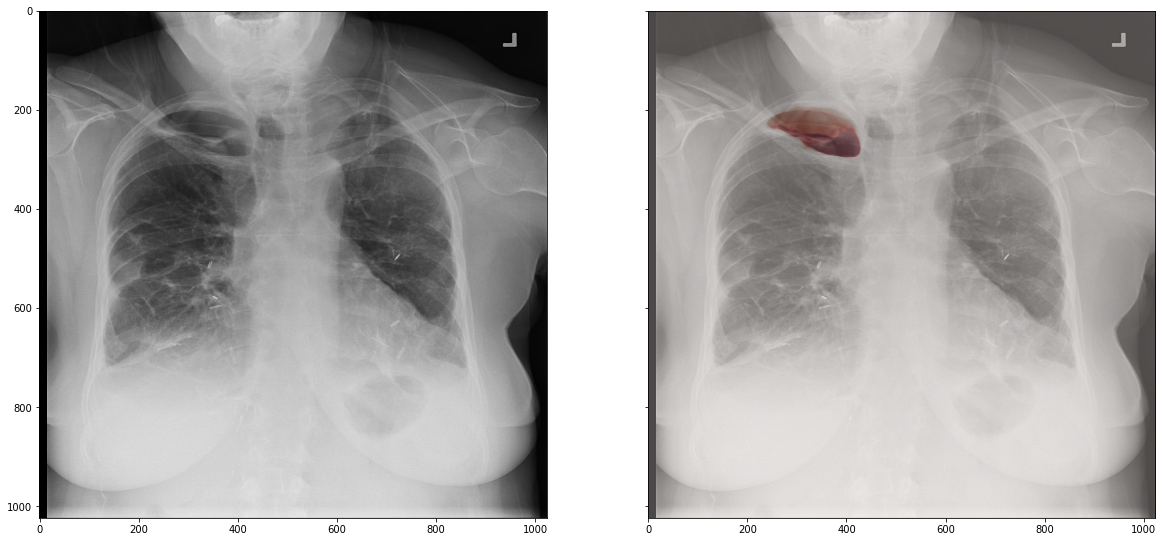

In [10]:
base_trans = get_base_transforms(image_size = 1024)
    
file_path = 'siim/1.2.276.0.7230010.3.1.4.8323329.5698.1517875189.651635.png'
image_id = file_path.split('/')[-1][:-4]

print(image_id)

original_img = cv2.imread(file_path)

# apply base transforms (albumentation)
img = base_trans(image=original_img)

# make it into a batch
img = img['image'].unsqueeze(0)

# apply TTA
masks = []
logits = []
for t in TTA: # custom transforms or e.g. tta.aliases.d4_transform() 
    
    # augment image
    augmented_image = t.augment_image(img).to(device)
    
    # pass to model and get the prediction
    with torch.no_grad():
        model.eval()
        model_output = model(augmented_image)
    
    # reverse augmentation for mask and label
    deaug_mask = t.deaugment_mask(model_output[0])
    deaug_logits = t.deaugment_label(model_output[1])
    
    # save results
    masks.append(deaug_mask)
    logits.append(deaug_logits)
    
# reduce results as you want, e.g mean/max/min
masks = torch.cat(masks,dim=0).cpu()
mask = torch.sigmoid(masks.mean(dim=0).squeeze(0)).cpu()

logits = torch.cat(logits,dim=0)
pred_pneut = torch.sigmoid(logits.mean(dim=0))

# we can either plot this or apply some 
# thresholding to make the mask crispier

prediction_criterion = pred_pneut < 0.4 or mask.sum() < 800

print(pred_pneut)
print(mask.sum())

if prediction_criterion :
    print('No Pneumothorax Predicted')
    plt.figure(figsize=(10,10))
    plt.imshow(original_img)
else:
    print('Pneumothorax Predicted')
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(20,10))
    ax1.imshow(original_img)
    ax2.imshow(original_img)
    ax2.imshow(mask, alpha=0.3, cmap="Reds") # we could use (mask>0.2) to output binary map

plt.show()

Ok, it works, so now 
### build up some helper functions and then run them systematically on every test image, to output a submission.csv

In [0]:
## Utils to transform the mas to RLE
def mask_to_rle(img):
    size = img.shape[0]
    assert size==img.shape[1] #square images
    rle = []
    lastColor = 0
    currentPixel = 0
    runStart = -1
    runLength = 0

    for x in range(size):
        for y in range(size):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 1:
                    runStart = currentPixel
                    runLength = 1
                else:
                    rle.append(str(runStart))
                    rle.append(str(runLength))
                    runStart = -1
                    runLength = 0
                    currentPixel = 0
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor
            currentPixel+=1
    # https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/discussion/98317
    if lastColor == 255:
        rle.append(runStart)
        rle.append(runLength)
    return " " + " ".join(rle)

In [0]:
mask_threshold = 0.2

binary_mask = (mask > mask_threshold).type(torch.uint8).T
  # T is weirdly important to maintain consistency with original dataset!
rle = mask_to_rle(binary_mask)

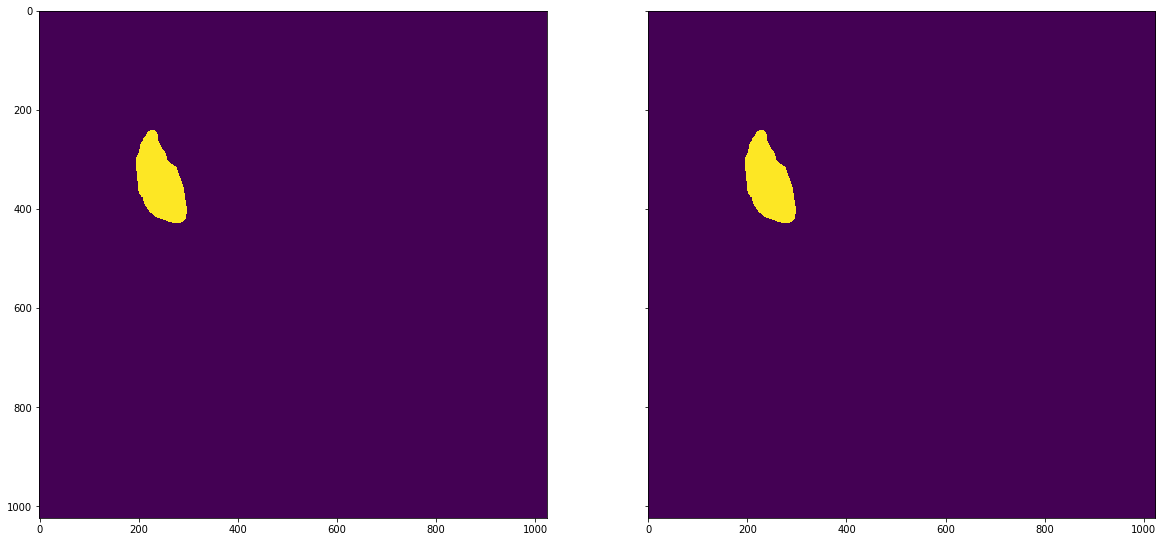

In [13]:
def rle_to_float_mask(rle, height=1024, width=1024, fill_value=1.):
    mask = np.zeros((height * width,), np.float32)
    rle = np.array([int(s) for s in rle.strip().split(' ')])
    rle = rle.reshape(-1, 2)
    start = 0
    for index, length in rle:
        start = start+index
        end = start+length
        mask[start: end] = fill_value
        start = end
    mask = mask.reshape(width, height)
    return mask

mask2 = rle_to_float_mask(rle)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(20,10))
ax1.imshow(binary_mask) 
ax2.imshow(mask2)

### The masks are correctly encoded, let's now refactor a little our procedure and then run it on the whole test set

In [0]:
# file_path = 'siim/1.2.276.0.7230010.3.1.4.8323329.5698.1517875189.651635.png'
## TODO, refactor the below functions to take arguments rather than global parameters
mask_threshold = 0.2


def image_to_pred(file_path):
    image_id = file_path.split('/')[-1][:-4]
    original_img = cv2.imread(file_path)

    # apply base transforms (albumentation)
    img = base_trans(image=original_img)

    # make it into a batch
    img = img['image'].unsqueeze(0)

    # apply TTA
    masks = []
    logits = []
    for t in TTA: # custom transforms or e.g. tta.aliases.d4_transform() 
        
        # augment image
        augmented_image = t.augment_image(img).to(device)
        
        # pass to model and get the prediction
        with torch.no_grad():
            model.eval()
            model_output = model(augmented_image)
        
        # reverse augmentation for mask and label
        deaug_mask = t.deaugment_mask(model_output[0])
        deaug_logits = t.deaugment_label(model_output[1])
        
        # save results
        masks.append(deaug_mask)
        logits.append(deaug_logits)
        
    # reduce results as you want, e.g mean/max/min
    masks = torch.cat(masks,dim=0).cpu()
    mask = torch.sigmoid(masks.mean(dim=0).squeeze(0)).cpu()

    logits = torch.cat(logits,dim=0)
    pred_pneut = torch.sigmoid(logits.mean(dim=0))

    return pred_pneut, mask


def image_to_rle(file_path):

    pred_pneut, mask = image_to_pred(file_path)
    # we can either plot this or apply some 
    # thresholding to make the mask crispier

    prediction_criterion = pred_pneut < 0.4 or mask.sum() < 800

    rle = '-1'
    if not prediction_criterion :
        binary_mask = (mask > mask_threshold).type(torch.uint8).T
        rle = mask_to_rle(binary_mask)

    return rle


In [15]:
df = pd.read_csv('siim/stage_2_sample_submission.csv')
df.head()

ImageId  EncodedPixels
0  ID_0011fe81e             -1
1  ID_9ca06e9b9             -1
2  ID_6f00d6ce6             -1
3  ID_9258110b0             -1
4  ID_fa01c9546             -1

In [1]:
# for some reason the notebook version isn't showing, so use the plaintext one
from tqdm import tqdm as tqdm_old

In [17]:
sublist = []

for index, row in tqdm_old(df.iterrows(), total=len(df)):
    image_id = row['ImageId']
    img_path = os.path.join('siim/test_png', image_id + '.png')
    rle = image_to_rle(img_path)
    sublist.append([image_id, rle])

submission_df = pd.DataFrame(sublist, columns=df.columns.values)
submission_df.to_csv('siim/submission.csv', index=False)
submission_df.head(50)

100%|██████████| 3205/3205 [2:50:20<00:00,  3.19s/it]

0


ImageId                                      EncodedPixels
0   ID_0011fe81e                                                 -1
1   ID_9ca06e9b9                                                 -1
2   ID_6f00d6ce6                                                 -1
3   ID_9258110b0                                                 -1
4   ID_fa01c9546   328943 7 1015 10 1013 11 1013 10 1013 10 1014...
5   ID_dffca7dc0                                                 -1
6   ID_2cfbe75a7                                                 -1
7   ID_29804aff4   303390 6 1015 11 1010 15 1006 18 1004 20 1002...
8   ID_f41bcffb6                                                 -1
9   ID_ad14240a7                                                 -1
10  ID_438a1bc12                                                 -1
11  ID_8dbfc31c5                                                 -1
12  ID_6f4413f2a                                                 -1
13  ID_ffb1eed56                                                 -1
14  ID_dd3eac33a                                                 -1
15  ID_16dfebefc                                                 -1
16  ID_83859a816                                                 -1
17  ID_8f1337226                                                 -1
18  ID_cb7273c22   209316 8 1008 18 1000 26 992 36 983 43 977 49...
19  ID_fdedf0fda                                                 -1
20  ID_168372be6                                                 -1
21  ID_c832ccaba                                                 -1
22  ID_91118a0e2                                                 -1
23  ID_7f554a3b1                                                 -1
24  ID_fda4b28bd                                                 -1
25  ID_8f0a96697   245963 6 1016 8 3 3 1009 15 1008 17 1005 19 1...
26  ID_ed6199ec4                                                 -1
27  ID_6032a999d   799376 1 1022 3 1021 4 1020 5 1018 6 1018 7 1...
28  ID_5fc668ff5                                                 -1
29  ID_bd20a4fde                                                 -1
30  ID_9a189a070                                                 -1
31  ID_81ef03e77   637074 11 1008 22 998 28 992 33 989 35 948 17...
32  ID_65fe84839                                                 -1
33  ID_2b785245f   502835 4 1015 9 1009 16 1006 19 1003 23 982 6...
34  ID_e969d9809   551125 18 1003 29 992 35 984 44 976 49 971 54...
35  ID_728643116                                                 -1
36  ID_087f48d7f                                                 -1
37  ID_b44ca6d6f                                                 -1
38  ID_48a7e89dc                                                 -1
39  ID_e155d1669   177716 4 1012 12 986 40 975 47 971 55 964 57 ...
40  ID_0e63f6a3c                                                 -1
41  ID_0930d8b45                                                 -1
42  ID_114609bb6                                                 -1
43  ID_59b2d5617                                                 -1
44  ID_643e7e94d                                                 -1
45  ID_7c5365a3b                                                 -1
46  ID_4849f1c95                                                 -1
47  ID_e8757ec0a                                                 -1
48  ID_81dd08780                                                 -1
49  ID_109413840                                                 -1

## Seems good! The submitted csv to Kaggle return a score of 0.8433, right around the 86th position out ~1500 teams! 
🎉

![score](images/score.png)

![leaderboard](images/leaderboard.png)


### Let's now visualize a few samples out of curiosity!

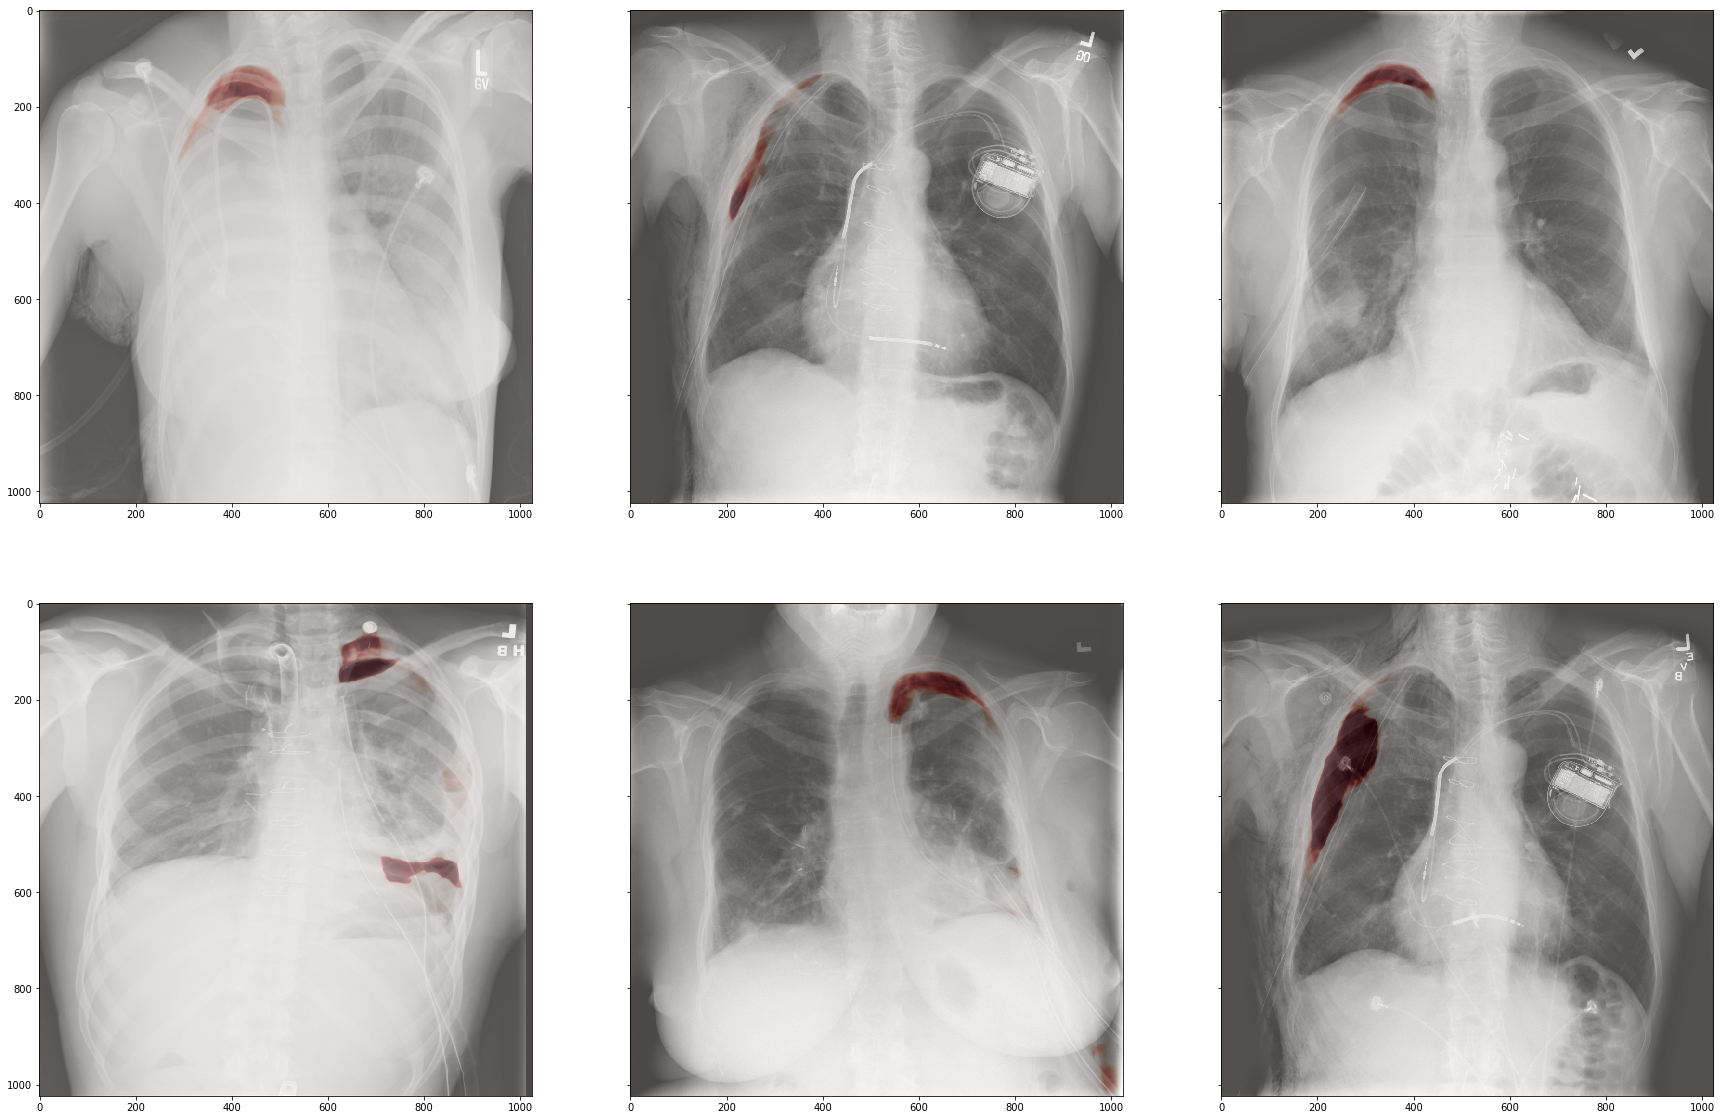

In [35]:
indexes = [4, 18, 25, 31, 34, 39] #hand picked images from the first 50 showed, to be sure I'm plotting images with masks!
f, ax = plt.subplots(2,3, sharey=True,figsize=(30,20))

for i,idx in enumerate(indexes):
    img_path = os.path.join('siim/test_png', df['ImageId'][idx] + '.png')
    original_img = cv2.imread(img_path)

    pred_pneut, mask = image_to_pred(img_path)

    prediction_criterion = pred_pneut < 0.4 or mask.sum() < 800

    ax[i//3,i%3].imshow(original_img)
    if not prediction_criterion :
        ax[i//3,i%3].imshow(mask, alpha=0.3, cmap="Reds")

plt.show()